In [1]:
import requests
import json
import time
import numpy as np


class DronePhysicsClient:
    def __init__(self, base_url="http://localhost:8080"):
        self.base_url = base_url
        self.session = requests.Session()

    def simulate_step(self, motor_thrusts, steps=1):
        """
        Simulate one or more physics steps with given motor thrusts.

        Args:
            motor_thrusts: List or array of 4 thrust values for motors
            steps: Number of simulation steps to run

        Returns:
            Dict containing drone state or error information
        """
        url = f"{self.base_url}/simulate"
        payload = {
            "motor_thrusts": list(motor_thrusts),
            "steps": steps
        }

        try:
            response = self.session.post(url, json=payload)
            response.raise_for_status()
            return response.json()
        except requests.exceptions.RequestException as e:
            return {"success": False, "error": str(e)}

    def reset_simulation(self):
        """Reset the simulation to initial state."""
        url = f"{self.base_url}/reset"

        try:
            response = self.session.post(url)
            response.raise_for_status()
            return response.json()
        except requests.exceptions.RequestException as e:
            return {"success": False, "error": str(e)}

    def get_state(self):
        """Get current state of simulation without stepping."""
        url = f"{self.base_url}/state"

        try:
            response = self.session.get(url)
            response.raise_for_status()
            return response.json()
        except requests.exceptions.RequestException as e:
            return {"success": False, "error": str(e)}

    def health_check(self):
        """Check if the API server is running."""
        url = f"{self.base_url}/health"

        try:
            response = self.session.get(url, timeout=5)
            response.raise_for_status()
            return response.json()
        except requests.exceptions.RequestException as e:
            return {"status": "error", "error": str(e)}

In [2]:
client = DronePhysicsClient()

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from quadcopter_control.controller import QuadcopterController
from scipy.spatial.transform import Rotation as R
from tqdm import tqdm

In [4]:
# Sim Constants

DT_S = 1./ 60.

DRONE_MASS = 0.027
NEWTON_TO_RPM = 1

Ixx = 1.4e-5
Iyy = 1.4e-5
Izz = 2.17e-5

MIN_THRUST = 0.26477955 / 4 * 0.8
MAX_THRUST = 0.26477955 / 4 * 1.5

In [5]:
def reset():
    client.reset_simulation()

In [6]:
def sim_step(motors):
    motors = np.array([motors[0], motors[2], motors[3], motors[1]])

    # scale
    motors = motors * NEWTON_TO_RPM

    state = client.simulate_step(motors.tolist(), steps=1)['data']

    position = np.array([
        state['position'][0],
        state['position'][1],
        state['position'][2],
    ])

    velocity = np.array([
        state['velocity'][0],
        state['velocity'][1],
        state['velocity'][2],
    ])

    attitude = R.from_quat([
        state['rotation'][0],
        state['rotation'][1],
        state['rotation'][2],
        state['rotation'][3]
    ], scalar_first=True)

    omega = np.array([
        -state['angular_velocity'][0],
        -state['angular_velocity'][1],
        state['angular_velocity'][2],
    ])

    return {
        'position': position,
        'velocity': velocity,
        'attitude': attitude,
        'omega': omega
    }

In [7]:
quadcopter_controller = QuadcopterController(
    DT_S,
    DRONE_MASS * 0.99,
    Ixx, Iyy, Izz,
    0.2, 
    12, 5, 5, 
    0.03,
    MIN_THRUST, MAX_THRUST,
)

In [8]:
def tune_controller(
        target={
            "position": np.array([0, 0, 5]),
            "velocity": np.zeros(3),
            "acceleration": np.zeros(3),
            "attitude": R.from_quat([0, 0, 0, 1]),
        },
        kp_pqr=np.array([95.0, 95.0, 6.0]),
        kp_bank=0.0,
        kp_pos_z=0.0,
        kp_vel_z=0.0,
        ki_pos_z=0.0,
        kp_pos_xy=0.0,
        kp_yaw=0.0,
        kp_vel_xy=0.0,
        kappa=1.0,
        n_episodes=500,
):
    reset()

    quadcopter_controller.integrated_altitude_error = 0.0
    quadcopter_controller.set_gains(
        kp_pqr=kp_pqr,
        kp_bank=kp_bank,
        kp_pos_z=kp_pos_z,
        kp_vel_z=kp_vel_z,
        ki_pos_z=ki_pos_z,
        kp_pos_xy=kp_pos_xy,
        kp_yaw=kp_yaw,
        kp_vel_xy=kp_vel_xy,
        kappa=kappa
    )

    times = []
    positions = []
    velocities = []
    attitudes = []
    motors_ = []
    omegas = []

    state = sim_step([0, 0, 0, 0])

    t = 0
    for i in tqdm(range(n_episodes)):

        motors = quadcopter_controller.run_control(
            target['position'],
            target['velocity'],
            target['acceleration'],
            target['attitude'],
            state['position'],
            state['velocity'],
            state['omega'],
            state['attitude'],
        )
        motors_.append(motors)

        # accelerations.append(state['acceleration'])
        attitudes.append(state['attitude'].as_quat())
        positions.append(state['position'])
        omegas.append(state['omega'])
        velocities.append(state['velocity'])
        times.append(t)
        state = sim_step(motors)

        t += DT_S

    return (
        np.array(times),
        np.array(positions),
        np.array(velocities),
        np.array(attitudes),
        np.array(omegas),
        np.array(motors_)
    )

In [19]:
reset()
target = {
    "position": np.array([3, 3, 10]),
    "velocity": np.zeros(3),
    "acceleration": np.zeros(3),
    "attitude": R.from_quat([0, 0, 0, 1]),
}

In [23]:
(times, positions, velocities, attitudes, omegas, motors) =  tune_controller(
    kp_pqr=np.array([25, 25, 5]),
    ki_pos_z=2,
    kp_pos_z=6,
    kp_vel_z=12,
    kp_pos_xy=8.0,
    kp_vel_xy=8.0,
    kp_yaw=1.0,
    kp_bank=2.0,
    n_episodes=5500,
    target=target
)

100%|██████████| 5500/5500 [00:05<00:00, 1082.17it/s]


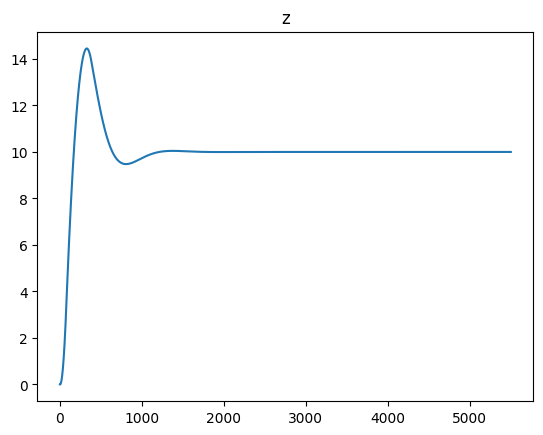

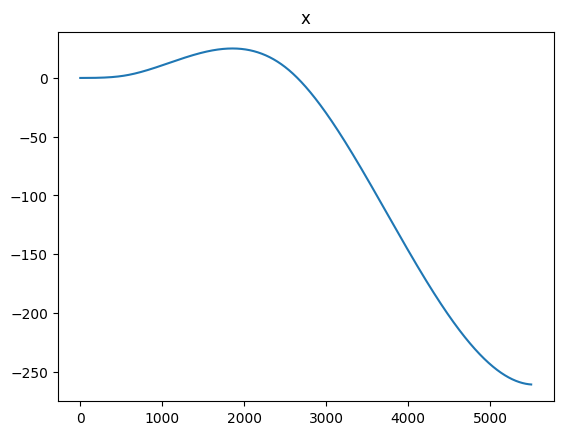

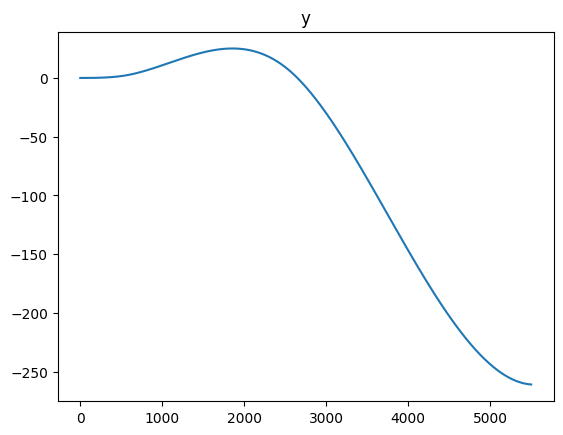

In [25]:
plt.title("z")
plt.plot(positions[:, 2])
plt.show()

plt.title("x")
plt.plot(positions[:, 0])
plt.show()

plt.title("y")
plt.plot(positions[:, 1])
plt.show()

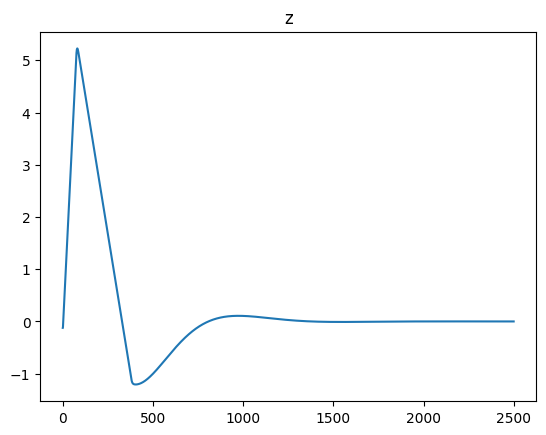

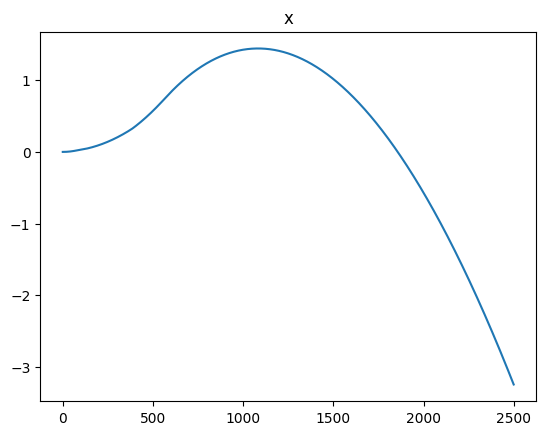

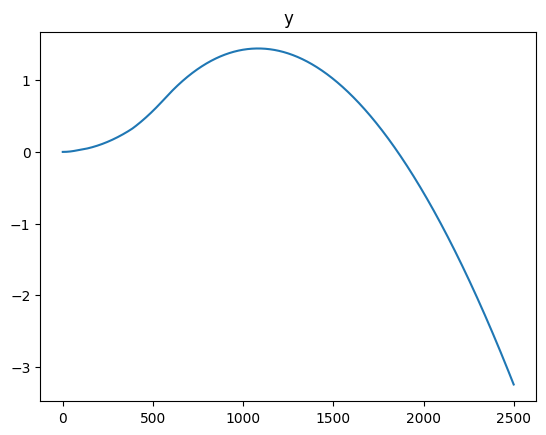

In [22]:
plt.title("z")
plt.plot(velocities[:, 2])
plt.show()

plt.title("x")
plt.plot(velocities[:, 0])
plt.show()

plt.title("y")
plt.plot(velocities[:, 1])
plt.show()

In [13]:
accel = np.gradient(velocities, DT_S, axis=0)

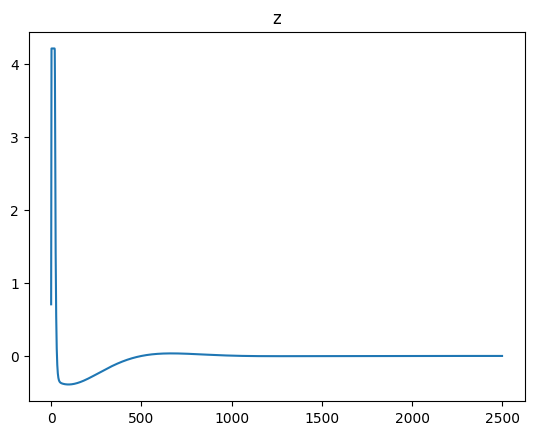

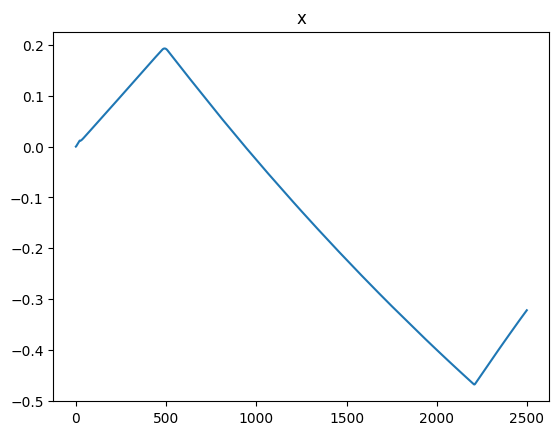

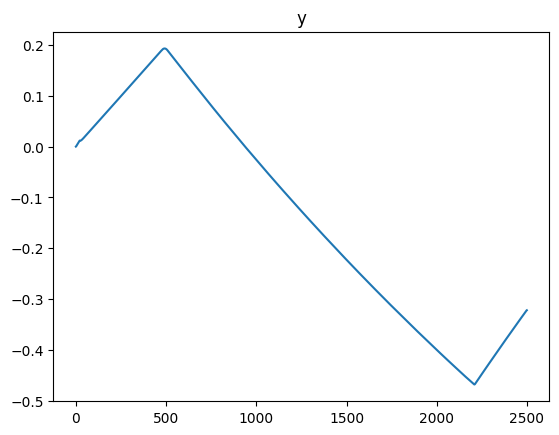

In [14]:
plt.title("z")
plt.plot(accel[:, 2])
plt.show()

plt.title("x")
plt.plot(accel[:, 0])
plt.show()

plt.title("y")
plt.plot(accel[:, 1])
plt.show()

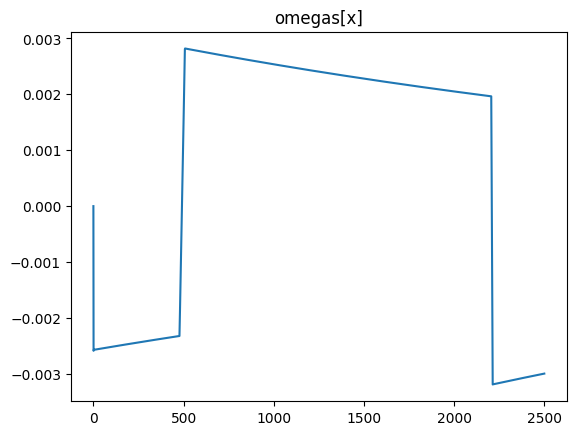

In [15]:
plt.title("omegas[x]")
plt.plot(omegas[:, 1])
plt.show()

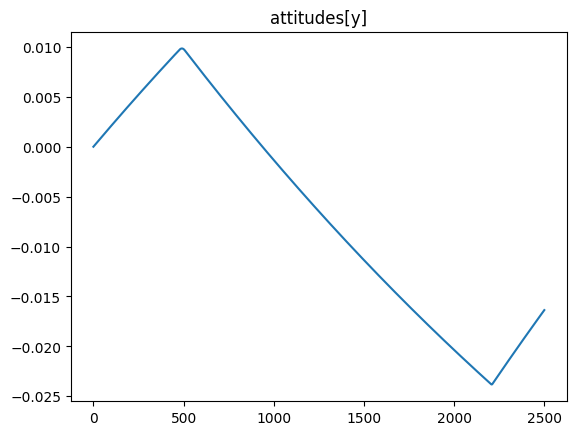

In [16]:
plt.title("attitudes[y]")
plt.plot(attitudes[:, 1])
plt.show()